# Modeling and Simulation in Python

Chapter 8: Pharmacokinetics

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


We'll start with the same code we saw last time: the magic command that tells Jupyter where to put the figures, and the import statement that gets the function defined in the `modsim` module.

In [1]:
# If you want the figures to appear in the notebook, 
# and you want to interact with them, use
# %matplotlib notebook

# If you want the figures to appear in the notebook, 
# and you don't want to interact with them, use
# %matplotlib inline

# If you want the figures to appear in separate windows, use
# %matplotlib qt|

# tempo switch from one to another, you have to select Kernel->Restart

%matplotlib inline

from modsim import *

In [2]:
df = pd.read_csv('glucose_insulin.csv', index_col='time')
df

,glucose,insulin
time,,
0,92,11
2,350,26
4,287,130
6,251,85
8,240,51
10,216,49
12,211,45
14,205,41
16,196,35


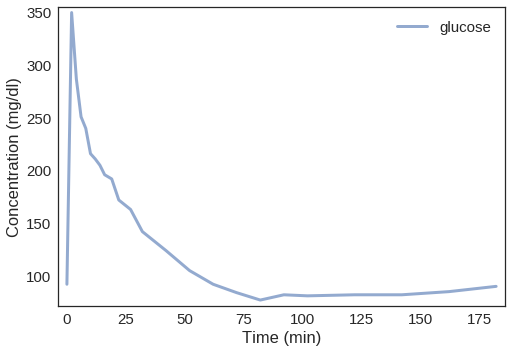

In [3]:
plot(df.glucose, label='glucose')
decorate(xlabel='Time (min)',
         ylabel='Concentration (mg/dl)')

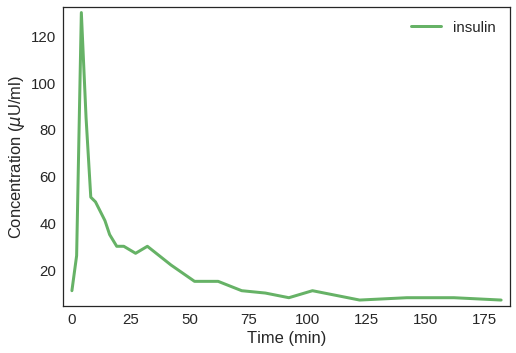

In [4]:
plot(df.insulin, color='green', label='insulin')
decorate(xlabel='Time (min)',
         ylabel='Concentration ($\mu$U/ml)')

Saving figure to file chap08-fig01.pdf


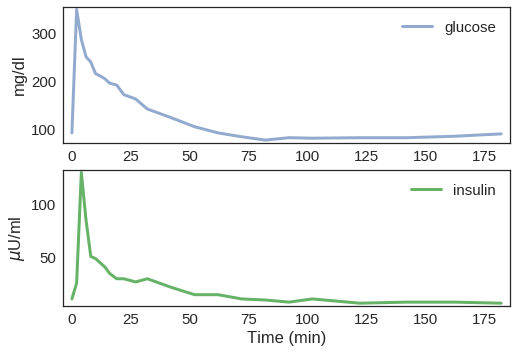

In [5]:
plt.subplot(2, 1, 1)
plot(df.glucose, label='glucose')
decorate(ylabel='mg/dl')

plt.subplot(2, 1, 2)
plot(df.insulin, color='green', label='insulin')
decorate(xlabel='Time (min)',
         ylabel='$\mu$U/ml')

savefig('chap08-fig01.pdf')

In [6]:
print(getsource(interpolate))

def interpolate(series, **options):
    """Creates an interpolation function.

    series: Series object
    options: any legal options to scipy.interpolate.interp1d

    returns: function that maps from the index of the series to its values 
    """
    underride(options, fill_value='extrapolate')
    return interp1d(series.index, series.values, **options)



In [7]:
I = interpolate(df.insulin)

In [8]:
I(18)

array(31.666666666666668)

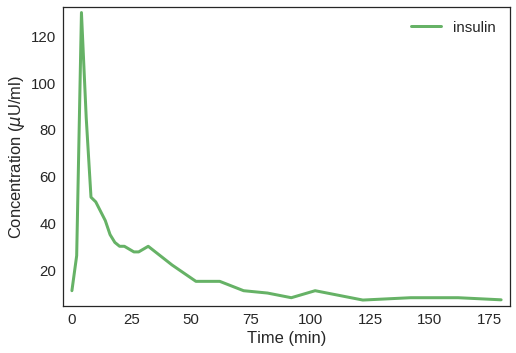

In [9]:
ts = arange(0, 182, 2)
plot(ts, I(ts), color='green', label='insulin')

decorate(xlabel='Time (min)',
         ylabel='Concentration ($\mu$U/ml)')

In [10]:
k1 = 0.03
k2 = 0.02
k3 = 1e-05
G0 = 290

In [11]:
S_I = k3 / k2
S_I

0.0005

In [12]:
Gb = df.glucose[0]
Ib = df.insulin[0]

In [13]:
init = State(G=G0, X=0)

In [14]:
system = System(init=init, 
                k1=k1, k2=k2, k3=k3,
                I=I, Gb=Gb, Ib=Ib,
                t0=0, t_end=182, dt=2)

In [15]:
def update_func(state, t, system):
    G, X = state
    unpack(system)
        
    dGdt = -k1 * (G - Gb) - X*G
    dXdt = k3 * (I(t) - Ib) - k2 * X
    
    G += dGdt * dt
    X += dXdt * dt

    return State(G=G, X=X)

In [16]:
update_func(init, 0, system)

,value
G,278.12
X,0.00


In [17]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
    
    Add a DataFrame to the System: results
    
    system: System object
    update_func: function that updates state
    """
    unpack(system)
    
    df = TimeFrame(columns=system.init.index)
    df.loc[t0] = system.init
    
    for t in arange(t0, t_end, dt):
        df.loc[t+dt] = update_func(df.loc[t], t, system)
    
    system.results = df

In [18]:
run_simulation(system, update_func)

In [19]:
system.results

,G,X
0,290,0
2,278.12,0
4,266.953,0.0003
6,256.295,0.002668
8,245.07,0.00404128
10,233.905,0.00467963
12,223.202,0.00525244
14,212.985,0.00572235
16,203.288,0.00609345
18,194.133,0.00632971


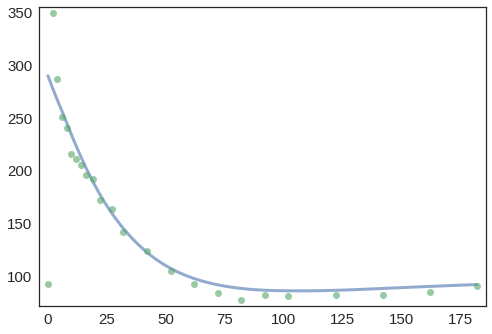

In [20]:
plot(system.results.G)
plot(df.glucose, style='o')

In [21]:
def slope_func(state, t, system):
    G, X = state
    unpack(system)
    
    dGdt = -k1 * (G - Gb) - X*G
    dXdt = k3 * (I(t) - Ib) - k2 * X
    
    return dGdt, dXdt

In [22]:
slope_func(init, 0, system)

(-5.9399999999999995, 0.0)

In [23]:
from scipy.integrate import odeint

def run_odeint(system, slope_func):
    """Runs a simulation of the system.
    
    Adds a DataFrame to the System: results
    
    system: System object
    slope_func: function that computes slopes
    """
    slope_func(init, 0, system)

    unpack(system)
    args = (system,)
    array = odeint(slope_func, init, ts, args)

    system.results = TimeFrame(array, columns=init.index, index=ts)

In [24]:
system = System(init=init, 
                k1=k1, k2=k2, k3=k3,
                I=I, Gb=Gb, Ib=Ib,
                ts=df.index)

In [25]:
run_odeint(system, slope_func)

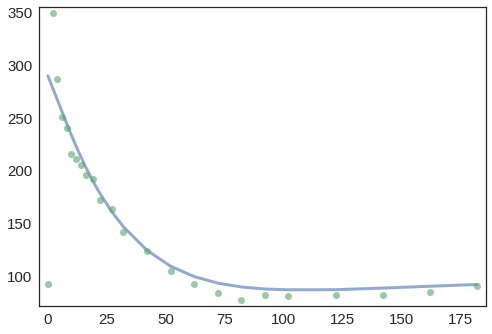

In [27]:
plot(system.results.G)
plot(df.glucose, style='o')

In [28]:
k1 = 0.03
k2 = 0.02
k3 = 1e-05
G0 = 290

In [29]:
def make_system(G0, k1, k2, k3):
    init = State(G=G0, X=0)
    system = System(init=init, 
                    k1=k1, k2=k2, k3=k3,
                    Gb=Gb, Ib=Ib, I=I,
                    ts=df.index)
    return system

In [56]:
def min_func(x, actual):
    print(x)
    system = make_system(*x)
    run_odeint(system, slope_func)
    error = system.results.G - actual
    error /= actual
    return error[3:]

In [57]:
params = G0, k1, k2, k3

In [58]:
min_func(params, df.glucose)

(290, 0.02672141497884439, 0.013368025131833635, 1.3229385667551067e-05)


time
6      0.029945
8      0.030424
10     0.093940
12     0.069272
14     0.050438
16     0.048552
19    -0.001406
22     0.041363
27    -0.015164
32     0.019131
42    -0.032652
52    -0.019755
62    -0.002050
72     0.008912
82     0.046514
92    -0.043629
102   -0.041582
122   -0.046578
142   -0.016894
162   -0.015882
182   -0.036028
dtype: float64

In [59]:
from scipy.optimize import leastsq

In [60]:
args = (df.glucose,)
popt, ier = leastsq(min_func, x0=params, args=args)

[  2.90000000e+02   2.67214150e-02   1.33680251e-02   1.32293857e-05]
[  2.90000000e+02   2.67214150e-02   1.33680251e-02   1.32293857e-05]
[  2.90000000e+02   2.67214150e-02   1.33680251e-02   1.32293857e-05]
[  2.90000004e+02   2.67214150e-02   1.33680251e-02   1.32293857e-05]
[  2.90000000e+02   2.67214154e-02   1.33680251e-02   1.32293857e-05]
[  2.90000000e+02   2.67214150e-02   1.33680253e-02   1.32293857e-05]
[  2.90000000e+02   2.67214150e-02   1.33680251e-02   1.32293859e-05]
[  2.90030027e+02   2.67310195e-02   1.34657877e-02   1.32490640e-05]
[  2.90030031e+02   2.67310195e-02   1.34657877e-02   1.32490640e-05]
[  2.90030027e+02   2.67310199e-02   1.34657877e-02   1.32490640e-05]
[  2.90030027e+02   2.67310195e-02   1.34657879e-02   1.32490640e-05]
[  2.90030027e+02   2.67310195e-02   1.34657877e-02   1.32490642e-05]
[  2.89940595e+02   2.67478083e-02   1.34432124e-02   1.32528493e-05]
[  2.89940600e+02   2.67478083e-02   1.34432124e-02   1.32528493e-05]
[  2.89940595e+02   

In [61]:
assert ier in [1, 2, 3, 4]
popt

array([  2.89940597e+02,   2.67478088e-02,   1.34432131e-02,
         1.32528498e-05])

In [62]:
system = make_system(*popt)
run_odeint(system, slope_func)

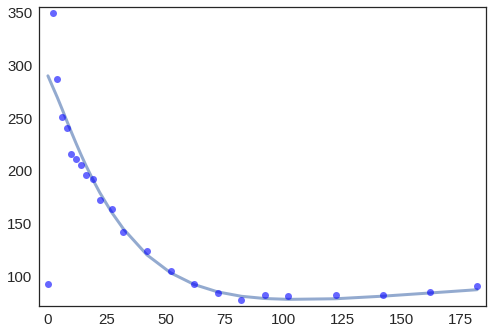

In [63]:
plot(system.results.G)
plot(df.glucose, style='bo')

In [64]:
def indices(G0, k1, k2, k3):
    return State(S_G=k1, S_I=k3/k2)

In [65]:
indices(*popt)

,value
S_G,0.026748
S_I,0.000986


In [66]:
stop

NameError: name 'stop' is not defined

**Exercise:**

In [ ]:
I0 = 363
k = 0.267
gamma = 0.0041
G_T = 83.7

In [ ]:
def make_system(I0, k, gamma, G_T):
    init = State(I=I0)
    system = System(init=init, k=k, gamma=gamma, G_T=G_T,
                    G_interp = interpolate(df.glucose),
                    t0=0, t_end=182)
    return system

In [ ]:
system = make_system(I0, k, gamma, G_T)
system

In [ ]:
def slope_func(state, t, system):
    I = state
    unpack(system)
    
    G = G_interp(t)
    if G > G_T:
        dIdt = gamma * (G - G_T) * (t - t0) - k * I
    else:
        dIdt = -k * I
    
    return dIdt

In [ ]:
slope_func(init, 0, system)

In [ ]:
def run_odeint(system, slope_func):
    """Runs a simulation of the system.
    
    Add a DataFrame to the System: results
    
    system: System object
    slope_func: function that computes slopes
    """
    unpack(system)

    ts = df.index
    args = system,
    array = odeint(slope_func, init, ts, args)

    system.results= TimeFrame(array, columns=init.index, index=ts)

In [ ]:
run_odeint(system, slope_func)
system.results

In [ ]:
plot(system.results)
plot(df.insulin)

In [ ]:
def min_func(ts, I0, k, gamma, G_T):
    print(I0, k, gamma, G_T)
    system = make_system(I0, k, gamma, G_T)
    run_odeint(system, slope_func)
    return system.results.I

In [ ]:
min_func(ts, I0, k, gamma, G_T)

In [ ]:
params = [I0, k, gamma, G_T]
params

In [ ]:
popt, pcov = curve_fit(min_func, df.insulin.index, df.insulin.values, p0=params)

In [ ]:
I0, k, gamma, G_T = popt

In [ ]:
system = make_system(*popt)

In [ ]:
run_odeint(system, slope_func)

In [ ]:
plot(system.results)
plot(df.insulin)

In [ ]:
I_max = df.insulin.max()
Ib = df.insulin[0]
I_max, Ib

In [ ]:
Gb = df.glucose[0]
G0, Gb

In [ ]:
phi_1 = (I_max - Ib) / k / (G0 - Gb)
phi_1

In [ ]:
phi_2 = gamma * 1e4
phi_2